In [ ]:
import pandas as pd
more_info = pd.read_feather("../../data/more_info.feather")

#checking out formatting
pd.set_option('display.max_colwidth', None)
print(more_info['keywords'].head())
print(more_info['headline'].head())


0                                                                                                                                                                                                       [{'name': 'persons', 'value': 'Dalton, Phyllis (1925-2025)', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Deaths (Obituaries)', 'rank': 2, 'major': 'N'}, {'name': 'subject', 'value': 'Costumes', 'rank': 3, 'major': 'N'}, {'name': 'subject', 'value': 'Movies', 'rank': 4, 'major': 'N'}, {'name': 'subject', 'value': 'Academy Awards (Oscars)', 'rank': 5, 'major': 'N'}, {'name': 'subject', 'value': 'Fashion and Apparel', 'rank': 6, 'major': 'N'}, {'name': 'glocations', 'value': 'England', 'rank': 7, 'major': 'N'}, {'name': 'creative_works', 'value': 'Doctor Zhivago (Movie)', 'rank': 8, 'major': 'N'}, {'name': 'creative_works', 'value': 'Henry V (Movie)', 'rank': 9, 'major': 'N'}, {'name': 'creative_works', 'value': 'Lawrence of Arabia (Movie)', 'rank': 10, 'major': 'N'}]
1           

Fishing with dynamite: bigram/trigram analysis

In [1]:
import nltk
from nltk.corpus import stopwords

# Download standard stopwords if you haven't already
nltk.download('stopwords')

# Start with standard English stopwords
custom_stopwords = set(stopwords.words('english'))

# Add your domain-specific words that you find too generic or uninformative
additional_stopwords = [
    # Generic political names/terms (you can add or remove as needed)
    "donald trump", "united states", "new york", "president", "biden", "trump",
    "prime minister", "kamala harris", "president elect", "biden administration",
    "vice president", "york city", "york times", "federal reserve", "officials said",
    "officials say", "years ago", "year old", "mr trump", "military said", "today episode",
    "president donald", "president trump", "president biden", "president kamala"
]

# Combine the lists
custom_stopwords = custom_stopwords.union(set(additional_stopwords))

# You can now see how many stopwords you have and inspect a few examples:
print("Number of custom stopwords:", len(custom_stopwords))
print("Some custom stopwords:", list(custom_stopwords)[:20])

Number of custom stopwords: 223
Some custom stopwords: ['yourself', "you'd", 'biden administration', 'am', 'down', 'has', 'years ago', 'if', 'isn', 'president donald', 'he', "he's", 'below', "doesn't", 'don', 'having', 'in', 'federal reserve', "he'd", 'of']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jocelynshek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd

# Combine text from columns
more_info['combined_text'] = (
    more_info['main_headline'].fillna('') + ' ' +
    more_info['abstract'].fillna('') + ' ' +
    more_info['lead_paragraph'].fillna('')
)

from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 20 bigrams
top_20_bigrams = get_top_ngrams(more_info['combined_text'], ngram_range=(2,2), n=40)

# Get top 20 trigrams
top_20_trigrams = get_top_ngrams(more_info['combined_text'], ngram_range=(3,3), n=40)

# Show results
print("Top 20 most frequent bigrams:")
for phrase, count in top_20_bigrams:
    print(f"{phrase}: {count}")

print("\nTop 20 most frequent trigrams:")
for phrase, count in top_20_trigrams:
    print(f"{phrase}: {count}")



NameError: name 'more_info' is not defined

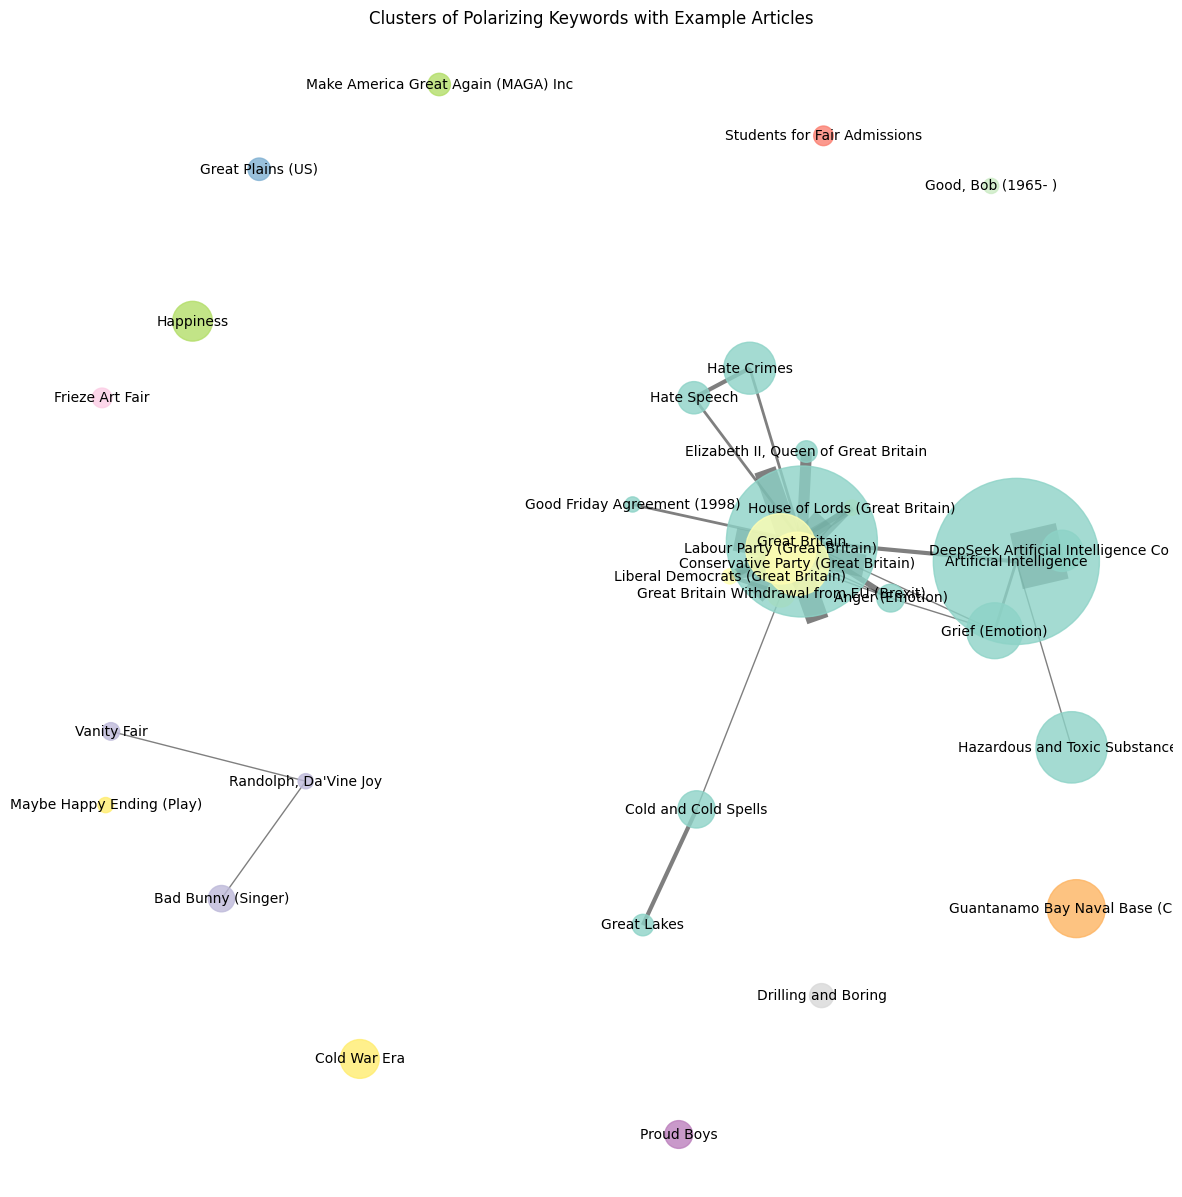

In [ ]:
import ast
import json
from collections import Counter, defaultdict
from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt

# --- Step 1: Robust extraction function ---
def extract_keyword_values(keyword_entry):
    if isinstance(keyword_entry, list):
        return [d['value'] for d in keyword_entry if isinstance(d, dict) and 'value' in d]
    elif isinstance(keyword_entry, str):
        try:
            data = json.loads(keyword_entry)
        except Exception:
            try:
                data = ast.literal_eval(keyword_entry)
            except Exception as e:
                print("Error parsing keywords:", e)
                return []
        return [d['value'] for d in data if isinstance(d, dict) and 'value' in d]
    else:
        return []

# --- Step 2: (Assuming you already have your DataFrame `more_info` and a 'combined_text' column) ---
# For example, if you haven't created 'combined_text' yet:
def combine_text(row):
    headline = row['headline'].get('main') if isinstance(row['headline'], dict) else str(row['headline']) or ''
    abstract = str(row['abstract']) if pd.notnull(row['abstract']) else ''
    lead = str(row['lead_paragraph']) if pd.notnull(row['lead_paragraph']) else ''
    return ' '.join([headline, abstract, lead])
    
more_info['combined_text'] = more_info.apply(combine_text, axis=1)

# --- Step 3: Define and calculate polarizing keywords (filtering step) ---
# (Using your previously defined filtering variables)
# For demonstration, suppose you already computed:
# keyword_counts and keyword_sentiments as in previous code.
# Here is a quick example:
all_keywords = []
for idx, row in more_info.iterrows():
    kws = extract_keyword_values(row['keywords'])
    all_keywords.extend(kws)
keyword_counts = Counter(all_keywords)
keyword_sentiments = {kw: TextBlob(kw).sentiment.polarity for kw in keyword_counts}

# Filter: Only keywords mentioned more than 5 times and with |polarity| > 0.5
polarizing_threshold = 0.5
filtered_keywords = {kw for kw, count in keyword_counts.items() 
                     if count > 5 and abs(keyword_sentiments[kw]) > polarizing_threshold}

# --- Step 4: Build co-occurrence counts and capture example article snippets ---
co_occurrence = defaultdict(lambda: defaultdict(int))
edge_examples = defaultdict(list)  # key: tuple (kw1, kw2) -> list of example snippets

for idx, row in more_info.iterrows():
    kws = extract_keyword_values(row['keywords'])
    # Only consider keywords in our filtered set
    kws = [kw for kw in kws if kw in filtered_keywords]
    kws = list(set(kws))  # remove duplicates from the same article
    # Use a snippet from combined_text as an example (e.g., first 100 characters)
    example = row['combined_text'][:100]
    for i in range(len(kws)):
        for j in range(i+1, len(kws)):
            key = tuple(sorted([kws[i], kws[j]]))
            co_occurrence[key[0]][key[1]] += 1
            # Save up to 2 examples per edge to avoid clutter
            if len(edge_examples[key]) < 2:
                edge_examples[key].append(example)

# --- Step 5: Build the network graph ---
G = nx.Graph()
# Add nodes with attributes (polarity, count)
for kw in filtered_keywords:
    G.add_node(kw, polarity=keyword_sentiments[kw], count=keyword_counts[kw])

edge_threshold = 1  # only add edges that occur at least once
for kw1, neighbors in co_occurrence.items():
    for kw2, weight in neighbors.items():
        if weight >= edge_threshold:
            G.add_edge(kw1, kw2, weight=weight)

# --- Step 6: Community detection (optional) ---
communities = nx.algorithms.community.greedy_modularity_communities(G)
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i
nx.set_node_attributes(G, community_map, 'community')

# --- Step 7: Visualization ---
plt.figure(figsize=(15, 15))
# Adjust spring layout parameters for more spacing:
pos = nx.spring_layout(G, k=1, iterations=100, seed=42)

# Color nodes by community
node_colors = [community_map[node] for node in G.nodes()]
node_sizes = [G.nodes[node]['count'] * 20 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.Set3,
                       node_color=node_colors, alpha=0.8)
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Clusters of Polarizing Keywords with Example Articles")
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Define thematic political keywords
political_keywords = [
    "Israel-Gaza War (2023- )",
    "United States International Relations",
    "Israel",
    "International Relations",
    "Gaza Strip",
    "Russian Invasion of Ukraine (2022)",
    "Russia",
    "Global Warming",
    "Palestinians",
    "Hamas",
    "China",
    "Ukraine",
    "United States Economy",
    "Black People",
    "Blacks",
    "Immigration and Emigration",
    "Terrorism",
    "Illegal Immigration",
    "Prices (Fares, Fees and Rates)",
    "International Trade and World Market",
    "Discrimination",
    "Hezbollah",
    "Abortion",
    "Race and Ethnicity",
    "Greenhouse Gas Emissions",
    "Banking and Financial Institutions",
    "Economic Conditions and Trends",
    "Protectionism (Trade)",
    "Factories and Manufacturing"
]


# Step 2: Filter articles with political keywords in 'keywords' column
def article_contains_keyword(keyword_list, keywords_column):
    for kw in keyword_list:
        if any(kw.lower() in entry.lower() for entry in keywords_column):
            return True
    return False

# Apply the filter
political_articles = more_info[
    more_info['keywords'].apply(lambda x: article_contains_keyword(political_keywords, extract_keyword_values(x)))
]

# Step 3: Combine relevant text columns (main_headline, abstract, lead_paragraph)
political_articles['combined_text'] = (
    political_articles['main_headline'].fillna('') + ' ' +
    political_articles['abstract'].fillna('') + ' ' +
    political_articles['lead_paragraph'].fillna('')
)

# Step 4: Extract top bigrams and trigrams from this subset
def get_top_ngrams(corpus, ngram_range=(2,2), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

# Get top 20 bigrams
top_political_bigrams = get_top_ngrams(political_articles['combined_text'], ngram_range=(2,2), top_n=20)

# Get top 20 trigrams
top_political_trigrams = get_top_ngrams(political_articles['combined_text'], ngram_range=(3,3), top_n=20)

# Display results
print("Top 20 bigrams from politically themed articles:")
for phrase, count in top_political_bigrams:
    print(f"{phrase}: {count}")

print("\nTop 20 trigrams from politically themed articles:")
for phrase, count in top_political_trigrams:
    print(f"{phrase}: {count}")


/var/folders/w6/3q8zk6j94wb5nxvb3y79cxjc0000gr/T/ipykernel_49927/993398222.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_articles['combined_text'] = (


Top 20 bigrams from politically themed articles:
donald trump: 1620
united states: 1385
new york: 950
president biden: 832
president trump: 781
prime minister: 701
kamala harris: 561
president elect: 479
biden administration: 451
vice president: 426
president donald: 424
climate change: 386
white house: 382
war gaza: 356
middle east: 348
elect donald: 341
supreme court: 332
trump administration: 328
israeli military: 328
benjamin netanyahu: 323

Top 20 trigrams from politically themed articles:
president donald trump: 424
elect donald trump: 341
president elect donald: 340
president kamala harris: 299
prime minister benjamin: 295
minister benjamin netanyahu: 295
vice president kamala: 295
new york city: 255
new york times: 252
president vladimir putin: 179
president volodymyr zelensky: 145
benjamin netanyahu israel: 134
israeli military said: 97
secretary state antony: 95
state antony blinken: 95
volodymyr zelensky ukraine: 93
vladimir putin russia: 92
bashar al assad: 74
mayor eric ad

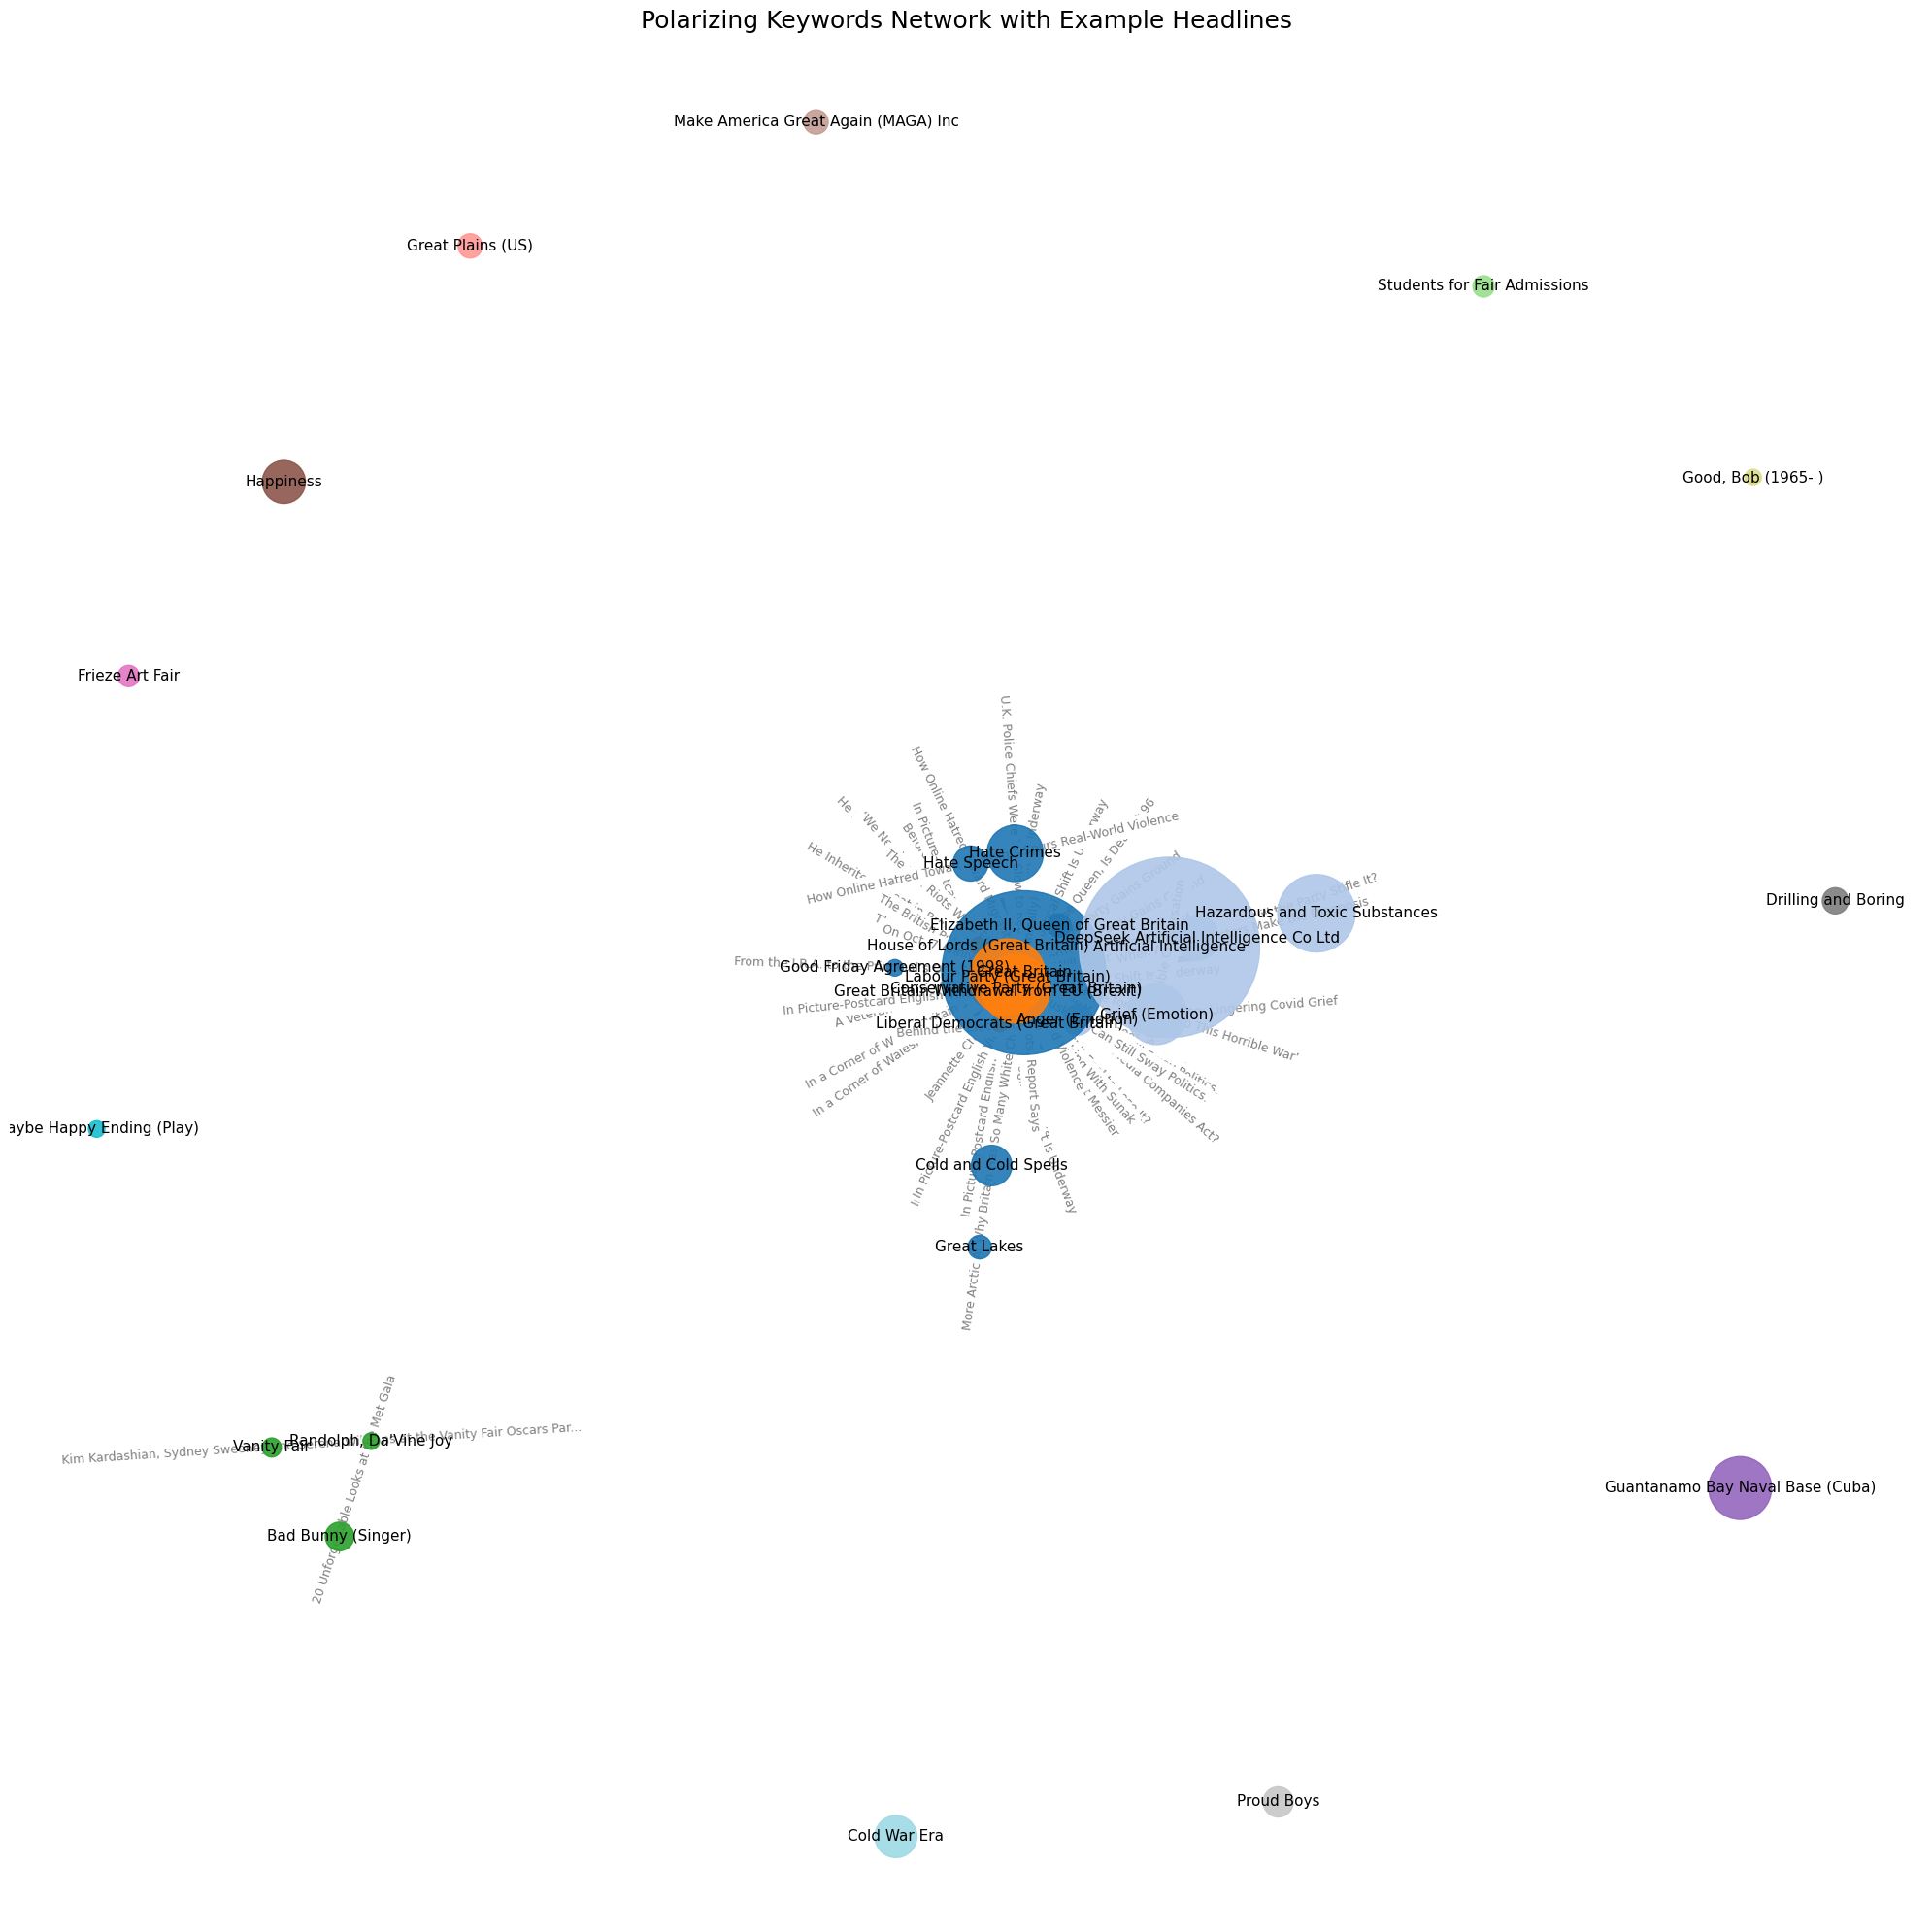

In [ ]:
import ast
import json
import pandas as pd
from collections import Counter, defaultdict
from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt

# Robust keyword extraction function
def extract_keyword_values(keyword_entry):
    if isinstance(keyword_entry, list):
        return [d['value'] for d in keyword_entry if isinstance(d, dict) and 'value' in d]
    elif isinstance(keyword_entry, str):
        try:
            data = json.loads(keyword_entry)
        except:
            try:
                data = ast.literal_eval(keyword_entry)
            except Exception as e:
                print("Error parsing keywords:", e)
                return []
        return [d['value'] for d in data if isinstance(d, dict) and 'value' in d]
    return []

# Count keywords and filter by sentiment/polarization threshold
all_keywords = [kw for kws in more_info['keywords'].apply(extract_keyword_values) for kw in kws]
keyword_counts = Counter(all_keywords)
keyword_sentiments = {kw: TextBlob(kw).sentiment.polarity for kw in keyword_counts}

polarizing_threshold = 0.5
filtered_keywords = {kw for kw, count in keyword_counts.items() 
                     if count > 5 and abs(keyword_sentiments[kw]) > polarizing_threshold}

# Build co-occurrence graph & attach example headlines


co_occurrence = defaultdict(lambda: defaultdict(int))
edge_examples = defaultdict(list)

for idx, row in more_info.iterrows():
    kws = extract_keyword_values(row['keywords'])
    kws = [kw for kw in kws if kw in filtered_keywords]
    kws = list(set(kws))
    example_headline = row['main_headline']
    for i in range(len(kws)):
        for j in range(i + 1, len(kws)):
            key = tuple(sorted([kws[i], kws[j]]))
            co_occurrence[key[0]][key[1]] += 1
            # Add only one good headline per edge to keep things readable
            if len(edge_examples[key]) < 1:
                edge_examples[key].append(example_headline)

# Create NetworkX graph
G = nx.Graph()

for kw in filtered_keywords:
    G.add_node(kw, polarity=keyword_sentiments[kw], count=keyword_counts[kw])

for kw1, neighbors in co_occurrence.items():
    for kw2, weight in neighbors.items():
        G.add_edge(kw1, kw2, weight=weight)

# Detect communities
communities = nx.algorithms.community.greedy_modularity_communities(G)
community_map = {node: i for i, community in enumerate(communities) for node in community}
nx.set_node_attributes(G, community_map, 'community')

# Visualization adjustments to spread out the nodes more clearly
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.8, iterations=200, seed=42)  # More spacing

# Node size and color by community
node_colors = [community_map[node] for node in G.nodes()]
node_sizes = [G.nodes[node]['count'] * 25 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.tab20, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=11)

# Attach example headlines clearly on edges
edge_labels = {(kw1, kw2): examples[0][:80] + "..." if len(examples[0]) > 80 else examples[0] 
               for (kw1, kw2), examples in edge_examples.items() if (kw1, kw2) in G.edges}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray', font_size=9)

plt.title("Polarizing Keywords Network with Example Headlines", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import ast
import json
import pandas as pd
from collections import Counter, defaultdict
from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# -------------------------
# Setup: Download and create custom stopword list
# -------------------------
nltk.download('stopwords')
custom_stopwords = set(stopwords.words('english'))
additional_stopwords = [
    "united", "new york",
    "prime minister", "president elect", "york city", "york times", "federal reserve", "officials said",
    "officials say", "years ago", "year old", "military said", "today episode", "said",
    "york", "years", "new", "year", "last week", "prime minister", "benjamin", "last", "good morning"
]
custom_stopwords = custom_stopwords.union(set(additional_stopwords))

# -------------------------
# Step 1: Filter politically themed articles
# -------------------------
political_keywords = [
    "Israel-Gaza War (2023- )", "United States International Relations", "Israel",
    "International Relations", "Gaza Strip", "Russian Invasion of Ukraine (2022)",
    "Russia", "Global Warming", "Palestinians", "Hamas", "China", "Ukraine",
    "United States Economy", "Black People", "Blacks", "Immigration and Emigration",
    "Terrorism", "Illegal Immigration", "Prices (Fares, Fees and Rates)",
    "International Trade and World Market", "Discrimination", "Hezbollah", "Abortion",
    "Race and Ethnicity", "Greenhouse Gas Emissions", "Banking and Financial Institutions",
    "Economic Conditions and Trends", "Protectionism (Trade)", "Factories and Manufacturing"
]

def article_contains_keyword(keyword_list, keywords_entry):
    def extract_keyword_values(keyword_entry):
        if isinstance(keyword_entry, list):
            return [d['value'] for d in keyword_entry if isinstance(d, dict) and 'value' in d]
        elif isinstance(keyword_entry, str):
            try:
                data = json.loads(keyword_entry)
            except Exception:
                try:
                    data = ast.literal_eval(keyword_entry)
                except Exception:
                    return []
            return [d['value'] for d in data if isinstance(d, dict) and 'value' in d]
        else:
            return []
    kws = extract_keyword_values(keywords_entry)
    for kw in keyword_list:
        if any(kw.lower() in k.lower() for k in kws):
            return True
    return False

political_articles = more_info[more_info['keywords'].apply(lambda x: article_contains_keyword(political_keywords, x))].copy()

# -------------------------
# Step 2: Combine text for n-gram extraction
# -------------------------
political_articles['combined_text'] = (
    political_articles['main_headline'].fillna('') + ' ' +
    political_articles['abstract'].fillna('') + ' ' +
    political_articles['lead_paragraph'].fillna('')
)

# -------------------------
# Step 3: Extract top n-grams (bigrams and trigrams) using custom stopwords
# -------------------------


def get_top_ngrams(corpus, ngram_range=(2,3), top_n=300, stop_words=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=list(stop_words) if stop_words is not None else None).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]


# --- Normalize & collapse top phrases ---
from collections import defaultdict

def normalize_phrase(phrase):
    phrase_lower = phrase.lower()
    if "biden administration" in phrase_lower:
        return "biden administration"
    if "trump administration" in phrase_lower:
        return "trump administration"
    if "harris administration" in phrase_lower:
        return "harris administration"
    if "trump" in phrase_lower or "donald" in phrase_lower:
        return "trump"
    if "biden" in phrase_lower or "joe" in phrase_lower:
        return "biden"
    if "harris" in phrase_lower or "kamala" in phrase_lower:
        return "harris"
    return phrase_lower

# Collapse frequencies
collapsed_freqs = defaultdict(int)
for phrase, count in top_phrases:
    normalized = normalize_phrase(phrase)
    collapsed_freqs[normalized] += count

# Keep only top N phrases
top_n = 300
collapsed_freqs = dict(sorted(collapsed_freqs.items(), key=lambda x: x[1], reverse=True)[:top_n])
top_phrase_list = list(collapsed_freqs.keys())

excluded_entities = {"trump", "biden", "harris", "kamala", "biden administration", "trump administration", "harris administration"}

co_occurrence = defaultdict(lambda: defaultdict(int))

for idx, row in political_articles.iterrows():
    text = row['combined_text'].lower()
    present = [normalize_phrase(p) for p in top_phrase_list if p in text]
    present = list(set(present))
    for i in range(len(present)):
        for j in range(i+1, len(present)):
            p1, p2 = sorted([present[i], present[j]])
            co_occurrence[p1][p2] += 1

G_full = nx.Graph()
for phrase in top_phrase_list:
    G_full.add_node(phrase, frequency=collapsed_freqs.get(phrase, 0))

for p1, neighbors in co_occurrence.items():
    for p2, weight in neighbors.items():
        if weight >= edge_threshold:
            G_full.add_edge(p1, p2, weight=weight)

G_full.remove_nodes_from(list(nx.isolates(G_full))) #lowkey don't even know if this is effective

from textblob import TextBlob

# Add sentiment as a node attribute
for node in G_full.nodes():
    phrase = node
    sentiment = TextBlob(phrase).sentiment.polarity  # ranges from -1 (negative) to +1 (positive)
    G_full.nodes[node]['sentiment'] = sentiment

for node in G_peopleless.nodes():
    phrase = node
    sentiment = TextBlob(phrase).sentiment.polarity
    G_peopleless.nodes[node]['sentiment'] = sentiment


G_peopleless = nx.Graph()

# Filter phrases
top_phrases_filtered = [p for p in top_phrase_list if p not in excluded_entities]

for phrase in top_phrases_filtered:
    G_peopleless.add_node(phrase, frequency=collapsed_freqs.get(phrase, 0))

for p1, neighbors in co_occurrence.items():
    if p1 not in excluded_entities:
        for p2, weight in neighbors.items():
            if p2 not in excluded_entities and weight >= edge_threshold:
                G_peopleless.add_edge(p1, p2, weight=weight)

G_peopleless.remove_nodes_from(list(nx.isolates(G_peopleless)))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jocelynshek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'top_phrases' is not defined

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx

# --- Set up exclusion list for people terms ---
excluded_entities = {
    "trump", "biden", "harris", "kamala",
    "trump administration", "biden administration", "harris administration"
}

# --- Co-occurrence graph building function ---
def build_graph(top_phrase_list, collapsed_freqs, co_occurrence, exclude_entities=None):
    G = nx.Graph()

    for phrase in top_phrase_list:
        if exclude_entities and phrase in exclude_entities:
            continue
        G.add_node(phrase, frequency=collapsed_freqs.get(phrase, 0))

    for p1, neighbors in co_occurrence.items():
        if exclude_entities and p1 in exclude_entities:
            continue
        for p2, weight in neighbors.items():
            if exclude_entities and p2 in exclude_entities:
                continue
            if weight >= edge_threshold:
                G.add_edge(p1, p2, weight=weight)

    G.remove_nodes_from(list(nx.isolates(G)))
    return G

# --- Build co-occurrence map once ---
co_occurrence = defaultdict(lambda: defaultdict(int))
for idx, row in political_articles.iterrows():
    text = row['combined_text'].lower()
    present = [phrase for phrase in top_phrase_list if phrase in text]
    present = list(set(present))  # deduplicate per article
    for i in range(len(present)):
        for j in range(i + 1, len(present)):
            p1, p2 = sorted([present[i], present[j]])
            co_occurrence[p1][p2] += 1

# --- Build both graphs ---
edge_threshold = 3  # adjust as needed
G_full = build_graph(top_phrase_list, collapsed_freqs, co_occurrence)
G_peopleless = build_graph(top_phrase_list, collapsed_freqs, co_occurrence, exclude_entities=excluded_entities)

# --- Visualization function ---
def visualize_graph(G, title=""):
    # Community detection
    communities = nx.algorithms.community.greedy_modularity_communities(G)
    community_map = {}
    for i, comm in enumerate(communities):
        for node in comm:
            community_map[node] = i
    nx.set_node_attributes(G, community_map, 'community')

    # Layout and styling
    pos = nx.spring_layout(G, k=2.0, iterations=300, scale=3, seed=42)
    colors = plt.get_cmap('tab20').colors
    node_colors = [colors[community_map[node] % 20] for node in G.nodes()]
    node_sizes = [G.nodes[node]['frequency'] * 5 for node in G.nodes()]

    # Draw
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()])
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Plot both graphs ---
visualize_graph(G_full, title="Clusters of Frequent Bigrams & Trigrams (Including Political Figures)")
visualize_graph(G_peopleless, title="Clusters Without Political Figures (Peopleless View)")


In [ ]:
# Build co-occurrence from normalized phrases
co_occurrence = defaultdict(lambda: defaultdict(int))

for idx, row in political_articles.iterrows():
    text = row['combined_text'].lower()
    present = [normalize_phrase(p) for p in top_phrase_list if p in text]
    present = list(set(present))  # Remove duplicates
    for i in range(len(present)):
        for j in range(i+1, len(present)):
            p1, p2 = sorted([present[i], present[j]])
            co_occurrence[p1][p2] += 1

# Build graph
G = nx.Graph()
for phrase in top_phrase_list:
    G.add_node(phrase, frequency=collapsed_freqs.get(phrase, 0))

# Add edges (with threshold)
edge_threshold = 3
for p1, neighbors in co_occurrence.items():
    for p2, weight in neighbors.items():
        if weight >= edge_threshold:
            G.add_edge(p1, p2, weight=weight)

# Remove isolates
G.remove_nodes_from(list(nx.isolates(G)))


In [ ]:
from matplotlib.patches import Patch

def plot_graph_with_sentiment_borders(G, title="Louvain + Sentiment"):

    # --- 1. Louvain community detection ---
    import community as community_louvain
    partition = community_louvain.best_partition(G, weight='weight')
    nx.set_node_attributes(G, partition, 'community')

    # --- 2. Sentiment analysis (TextBlob) ---
    from textblob import TextBlob
    for node in G.nodes():
        sentiment = TextBlob(node).sentiment.polarity
        G.nodes[node]['sentiment'] = sentiment

    # --- 3. Layout ---
    pos = nx.spring_layout(G, k=2.0, iterations=300, scale=3, seed=42)

    # --- 4. Fill colors by cluster ---
    num_clusters = len(set(partition.values()))
    colors = cm.get_cmap('tab20', num_clusters)
    node_colors = [colors(partition[node]) for node in G.nodes()]

    # --- 5. Border color by sentiment ---
    border_colors = []
    for node in G.nodes():
        score = G.nodes[node]['sentiment']
        if score > 0.05:
            border_colors.append("green")
        elif score < -0.05:
            border_colors.append("red")
        else:
            border_colors.append("gray")

    # --- 6. Draw ---
    plt.figure(figsize=(20, 20))
    # First, draw transparent filled nodes to define size & location
    nx.draw_networkx_nodes(
        G, pos,
        node_size=[G.nodes[n]['frequency'] * 5 for n in G.nodes()],
        node_color=node_colors,
        edgecolors=border_colors,  # <== sentiment as border
        linewidths=2.5,
        alpha=0.9
    )
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()])
    nx.draw_networkx_labels(G, pos, font_size=9)

    # --- 7. Legend ---
    legend_elements = [
        Patch(facecolor="white", edgecolor="red", label="Negative Sentiment", linewidth=2),
        Patch(facecolor="white", edgecolor="gray", label="Neutral Sentiment", linewidth=2),
        Patch(facecolor="white", edgecolor="green", label="Positive Sentiment", linewidth=2),
    ]
    plt.legend(handles=legend_elements, loc="upper right", fontsize=12)

    plt.title(title, fontsize=24, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_graph_with_sentiment_borders(G_full, title="With Political Figures")
plot_graph_with_sentiment_borders(G_peopleless, title="Peopleless View")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import networkx as nx
from textblob import TextBlob
import community as community_louvain

def plot_graph_with_sentiment_gradient_borders(G, title="Louvain + Sentiment (Gradient Border)"):

    # --- 1. Community Detection (Louvain) ---
    partition = community_louvain.best_partition(G, weight='weight')
    nx.set_node_attributes(G, partition, 'community')

    # --- 2. Sentiment Analysis ---
    for node in G.nodes():
        sentiment = TextBlob(node).sentiment.polarity
        G.nodes[node]['sentiment'] = sentiment

    # --- 3. Layout ---
    pos = nx.spring_layout(G, k=2.0, iterations=300, scale=3, seed=42)

    # --- 4. Node Fill Color: Community ---
    num_clusters = len(set(partition.values()))
    cluster_colors = cm.get_cmap('tab20', num_clusters)
    node_colors = [cluster_colors(partition[node]) for node in G.nodes()]

    # --- 5. Node Border Color: Sentiment (continuous red→gray→green) ---
    sentiment_scores = [G.nodes[node]['sentiment'] for node in G.nodes()]
    norm = Normalize(vmin=-1, vmax=1)
    sentiment_cmap = cm.get_cmap("RdYlGn")  # Red to Yellow to Green
    border_colors = [sentiment_cmap(norm(score)) for score in sentiment_scores]

    # --- 6. Draw ---
    fig, ax = plt.subplots(figsize=(20, 20))
    nx.draw_networkx_nodes(
        G, pos,
        node_size=[G.nodes[n]['frequency'] * 5 for n in G.nodes()],
        node_color=node_colors,
        edgecolors=border_colors,
        linewidths=2.5,
        alpha=0.95,
        ax=ax
    )
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.4, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()])
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=9)


    # --- 7. Colorbar Legend ---
    sm = plt.cm.ScalarMappable(cmap=sentiment_cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.01)
    cbar.set_label('Sentiment Polarity', fontsize=14)

    plt.title(title, fontsize=24, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_graph_with_sentiment_gradient_borders(G_full, title="Louvain Clusters + Sentiment (With Political Figures)")
plot_graph_with_sentiment_gradient_borders(G_peopleless, title="Louvain Clusters + Sentiment (Peopleless)")



In [ ]:
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_louvain_clusters(G, title="Louvain Clustering"):
    # Compute partition
    partition = community_louvain.best_partition(G, weight='weight')
    nx.set_node_attributes(G, partition, 'community')

    # Layout
    pos = nx.spring_layout(G, k=2.0, iterations=300, scale=3, seed=42)
    communities = set(partition.values())
    colors = cm.get_cmap('tab20', len(communities))
    node_colors = [colors(partition[node]) for node in G.nodes()]
    node_sizes = [G.nodes[node]['frequency'] * 5 for node in G.nodes()]

    # Plot
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()])
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot both
plot_louvain_clusters(G_full, title="Louvain Clustering (With Political Figures)")
plot_louvain_clusters(G_peopleless, title="Louvain Clustering (Peopleless)")


In [ ]:
import spacy
nlp = spacy.load("en_core_web_md")  # or 'lg' for more accuracy

terms = list(G.nodes())  # or any list of keywords/phrases
term_vectors = {term: nlp(term).vector for term in terms}

from sklearn.cluster import KMeans
import numpy as np

X = np.array(list(term_vectors.values()))
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

term_to_cluster = dict(zip(term_vectors.keys(), kmeans.labels_))

import community as community_louvain

partition = community_louvain.best_partition(G, weight="weight")
for node in G.nodes():
    G.nodes[node]['community'] = partition[node]

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Layout for nodes
pos = nx.spring_layout(G, seed=42, k=0.8)

# Assign colors based on community
communities = set(partition.values())
colors = cm.get_cmap('tab20', len(communities))
node_colors = [colors(partition[node]) for node in G.nodes()]

#Same as 2, but cleaner color map with matplotlib.cm.get_cmap()
# spring_layout; creates a real colormap
# cleanest, most scalable version — good if you don’t know how many communities you’ll get.

plt.figure(figsize=(16, 16))

# Draw nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=100,
    node_color=node_colors,
    alpha=0.9
)

# Draw edges
nx.draw_networkx_edges(
    G, pos,
    alpha=0.3,
    width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()]
)

# Draw labels (optional — can clutter if too many)
nx.draw_networkx_labels(
    G, pos,
    font_size=8
)

plt.title("Louvain Community Clustering of Terms", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()




In [ ]:
import spacy
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

nlp = spacy.load("en_core_web_md")

def plot_semantic_tsne(G, title="Semantic Clusters (KMeans + t-SNE)"):
    term_list = list(G.nodes())
    term_vectors = np.array([nlp(term).vector for term in term_list])

    # KMeans clustering
    kmeans = KMeans(n_clusters=8, random_state=42)
    kmeans_labels = kmeans.fit_predict(term_vectors)
    semantic_clusters = dict(zip(term_list, kmeans_labels))
    nx.set_node_attributes(G, semantic_clusters, 'semantic_cluster')

    # t-SNE layout
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    embedding = tsne.fit_transform(term_vectors)
    pos = {term: (embedding[i, 0], embedding[i, 1]) for i, term in enumerate(term_list)}

    # Colors
    num_clusters = len(set(kmeans_labels))
    #colors = cm.get_cmap("tab10", num_clusters)
    from matplotlib.colors import ListedColormap
    import seaborn as sns

    palette = sns.color_palette("husl", n_colors=num_clusters)
    colors = ListedColormap(palette.as_hex())
    node_colors = [colors(kmeans_labels[i]) for i in range(len(term_list))]
    node_sizes = [G.nodes[term]['frequency'] * 5 for term in term_list]

    # Plot
    plt.figure(figsize=(16, 16))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()])
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot both
plot_semantic_tsne(G_full, title="Semantic Clusters (KMeans + t-SNE, With Political Figures)")
plot_semantic_tsne(G_peopleless, title="Semantic Clusters (KMeans + t-SNE, Peopleless)")


In [ ]:
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

def plot_semantic_tsne(G, title="Semantic Clusters (KMeans + t-SNE + Sentiment Borders)"):
    term_list = list(G.nodes())
    term_vectors = np.array([nlp(term).vector for term in term_list])

    # --- KMeans clustering ---
    kmeans = KMeans(n_clusters=8, random_state=42)
    kmeans_labels = kmeans.fit_predict(term_vectors)
    semantic_clusters = dict(zip(term_list, kmeans_labels))
    nx.set_node_attributes(G, semantic_clusters, 'semantic_cluster')

    # --- Sentiment scoring ---
    for node in term_list:
        sentiment = TextBlob(node).sentiment.polarity
        G.nodes[node]['sentiment'] = sentiment

    # --- t-SNE layout ---
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    embedding = tsne.fit_transform(term_vectors)
    pos = {term: (embedding[i, 0], embedding[i, 1]) for i, term in enumerate(term_list)}

    # --- Fill color: KMeans cluster (palette) ---
    num_clusters = len(set(kmeans_labels))
    palette = sns.color_palette("husl", n_colors=num_clusters)
    fill_cmap = ListedColormap(palette.as_hex())
    node_colors = [fill_cmap(kmeans_labels[i]) for i in range(len(term_list))]

    # --- Border color: Sentiment (gradient) ---
    sentiment_scores = [G.nodes[term]['sentiment'] for term in term_list]
    norm = Normalize(vmin=-1, vmax=1)
    sentiment_cmap = cm.get_cmap("RdYlGn")
    border_colors = [sentiment_cmap(norm(score)) for score in sentiment_scores]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(16, 16))

    nx.draw_networkx_nodes(
        G, pos,
        node_size=[G.nodes[term]['frequency'] * 5 for term in term_list],
        node_color=node_colors,
        edgecolors=border_colors,
        linewidths=2.5,
        alpha=0.95,
        ax=ax
    )
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()])
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=9)

    # --- Colorbar for sentiment ---
    sm = plt.cm.ScalarMappable(cmap=sentiment_cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.01)
    cbar.set_label('Sentiment Polarity', fontsize=14)

    plt.title(title, fontsize=24, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_semantic_tsne(G_full, title="Semantic Clusters + Sentiment (With Political Figures)")
plot_semantic_tsne(G_peopleless, title="Semantic Clusters + Sentiment (Peopleless)")
